In [1]:
import numpy as np
import argparse
from tqdm.notebook import tqdm
import gym
import safety_gym
import env as _env
from models import ProbEnsemble, PredictEnv
from cem.ccem import ConstrainedCEM
from mbrl_utils import *
from batch_utils import *
from sac import ReplayMemory

from simple_models import GaussianPolicy
from utils import Args

pygame 2.0.1 (SDL 2.0.14, Python 3.6.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import wandb
logged_data = {}
def mock_log(info):
    for key, value in info.items():
        if key not in logged_data:
            logged_data[key] = []
        logged_data[key].append(value)
    print(info)
wandb.log = mock_log

In [3]:
def no_cost_wrapper(env):
    env._og_step = env.step
    def step(*args):
        obs, rew, done, info = env._og_step(*args)
        info["cost"] = 0
        return obs, rew, done, info
    env.step = step
    return env

In [4]:
env_name = 'Safexp-PointGoal1-v0'
env = no_cost_wrapper(gym.make(env_name))

obs_shape = env.observation_space.shape
act_shape = env.action_space.shape
state_size = np.prod(obs_shape)
action_size = np.prod(act_shape)
policy = GaussianPolicy(obs_shape[0], act_shape[0])
policy_optim = torch.optim.Adam(policy.parameters())
def select_action(self, input, eval=False):
    return policy.select_action(input)
agent = Args(policy = policy, policy_optim = policy_optim, device = policy.device, select_action=select_action)

/home/andrew/miniconda3/envs/offline-saferl/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
def select_action(input, eval=False):
    return policy.select_action(input)
agent = Args(policy = policy, policy_optim = policy_optim, device = policy.device, select_action=select_action)

In [6]:
args = Args(
    num_epoch = 15,
    gamma = 0.99,
    replay_size = 2000000,
    hidden_size = 200,
    env = env_name,
    algo = "cem",
    real_ratio = 0.05,
    cuda = True,
    learn_cost = True,
    rollout_batch_size = 100000,
    rollout_length = 1,
    epoch_length = 1000,
    model_train_freq = 250,
    model_retain_epochs = 5,
    policy_train_batch_size = 256,
    eval_n_episodes = 10,
)

In [7]:
cost_size = 1 if args.learn_cost else 0

env_sampler = EnvSampler(env, max_path_length=args.epoch_length)
env_pool = ReplayMemory(args.replay_size)
env_model = ProbEnsemble(state_size, action_size, network_size=5,
                         reward_size=1+cost_size, hidden_size=args.hidden_size)
cem_agent = ConstrainedCEM(env)
cem_agent.set_model(env_model)
env_model.to('cuda')
predict_env = PredictEnv(env_model, args.env)

rollouts_per_epoch = args.rollout_batch_size * args.epoch_length / args.model_train_freq
model_steps_per_epoch = int(args.rollout_length * rollouts_per_epoch)
new_pool_size = args.model_retain_epochs * model_steps_per_epoch
expert_pool = ReplayMemory(new_pool_size)

/home/andrew/Documents/offline_safe_rl/models/ensemble.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(val, dtype=torch.float32)


In [8]:
total_step = 0
reward_sum = 0
rollout_length = args.rollout_length
exploration_before_start(args, env_sampler, env_pool, cem_agent)

for epoch_step in tqdm(range(args.num_epoch)):

    start_step = total_step
    train_policy_steps = 0
    epoch_reward = 0
    epoch_cost = 0
    for i in range(args.epoch_length):
        cur_step = total_step - start_step

        # epoch_length = 1000, min_pool_size = 1000
        if cur_step >= args.epoch_length and len(env_pool) > 1000:
            break

        if cur_step % args.model_train_freq == 0 and args.real_ratio < 1.0:
            assert(args.algo not in ['sac', 'cql'])
            train_predict_model(args, env_pool, predict_env)
            cem_agent.set_model(predict_env.model)

        # plan CEM action
        cur_state, action, next_state, reward, done, info = env_sampler.sample(cem_agent)
        env_pool.push(cur_state, action, reward, next_state, done)
        expert_pool.push(cur_state, action, reward, next_state, done)

        epoch_reward += reward[0]
        epoch_cost += reward[1]
        total_step += 1

#     for _ in range(100):
#         expert_states, expert_actions, _, _, _ = expert_pool.sample(args.policy_train_batch_size)
#         expert_states = torch.FloatTensor(expert_states).to(agent.device)
#         expert_actions = torch.FloatTensor(expert_actions).to(agent.device)
#         agent.policy_optim.zero_grad()
#         # mean, _ = agent.policy(expert_states)
#         # policy_loss = torch.nn.MSELoss()(mean, expert_actions)
#         log_prob, _, _ = agent.policy.log_prob(expert_states, expert_actions)
#         policy_loss = log_prob.mean()
#         policy_loss.backward()
#         agent.policy_optim.step()
#         loss_val = policy_loss.cpu().detach().item()
#         wandb.log({"Policy/loss": loss_val})

#     rewards = [evaluate_policy(args, env_sampler, agent, args.epoch_length) for _ in range(args.eval_n_episodes)]
#     rewards = np.array(rewards)

#     rewards_avg = np.mean(rewards, axis=0)
#     rewards_std = np.std(rewards, axis=0)
    print("")
    print(f'Epoch {epoch_step} Train_Reward {epoch_reward:.2f} Train_Cost {epoch_cost:.2f}')
#     print(f'Epoch {epoch_step} Eval_Reward {rewards_avg[0]:.2f} Eval_Cost {rewards_avg[1]:.2f}')
    wandb.log({'Eval/epoch':epoch_step,
               'Train/epoch_reward': epoch_reward,
               'Train/epoch_cost': epoch_cost,
#                'Eval/eval_reward': rewards_avg[0],
#                'Eval/eval_cost': rewards_avg[1],
#                'Eval/reward_std': rewards_std[0],
#                'Eval/cost_std': rewards_std[1]
              })

  0%|          | 0/15 [00:00<?, ?it/s]

{'Model/model_nll': -2.5281543731689453, 'Model/model_rmse': 0.31266477704048157}
{'Model/model_nll': -3.0310304164886475, 'Model/model_rmse': 0.2945516109466553}
{'Model/model_nll': -3.323488712310791, 'Model/model_rmse': 0.282903790473938}
{'Model/model_nll': -3.651320219039917, 'Model/model_rmse': 0.27942511439323425}

Epoch 0 Train_Reward 3.21 Train_Cost 0.00
{'Eval/epoch': 0, 'Train/epoch_reward': 3.208643958694538, 'Train/epoch_cost': 0.0}
{'Model/model_nll': -3.8567585945129395, 'Model/model_rmse': 0.27929890155792236}
{'Model/model_nll': -3.9023842811584473, 'Model/model_rmse': 0.280428022146225}
{'Model/model_nll': -3.9165446758270264, 'Model/model_rmse': 0.2845662534236908}
{'Model/model_nll': -4.098943710327148, 'Model/model_rmse': 0.2842317521572113}

Epoch 1 Train_Reward -6.89 Train_Cost 0.00
{'Eval/epoch': 1, 'Train/epoch_reward': -6.893804417492471, 'Train/epoch_cost': 0.0}
{'Model/model_nll': -4.210461616516113, 'Model/model_rmse': 0.2876037657260895}
{'Model/model_nll'

In [9]:
    rewards = [evaluate_policy(args, env_sampler, agent, args.epoch_length) for _ in range(args.eval_n_episodes)]
    rewards = np.array(rewards)

    rewards_avg = np.mean(rewards, axis=0)
    rewards_std = np.std(rewards, axis=0)
    print("")
    print(f'Epoch {epoch_step} Train_Reward {epoch_reward:.2f} Train_Cost {epoch_cost:.2f}')
    print(f'Epoch {epoch_step} Eval_Reward {rewards_avg[0]:.2f} Eval_Cost {rewards_avg[1]:.2f}')
    wandb.log({'Eval/epoch':epoch_step,
               'Train/epoch_reward': epoch_reward,
               'Train/epoch_cost': epoch_cost,
               'Eval/eval_reward': rewards_avg[0],
               'Eval/eval_cost': rewards_avg[1],
               'Eval/reward_std': rewards_std[0],
               'Eval/cost_std': rewards_std[1]})


Epoch 14 Train_Reward -0.22 Train_Cost 0.00
Epoch 14 Eval_Reward -0.34 Eval_Cost 0.00
{'Eval/epoch': 14, 'Train/epoch_reward': -0.22042396032646583, 'Train/epoch_cost': 0.0, 'Eval/eval_reward': -0.343640685955222, 'Eval/eval_cost': 0.0, 'Eval/reward_std': 0.6444941399960774, 'Eval/cost_std': 0.0}


In [10]:
epoch_reward = 0
for i in tqdm(range(args.epoch_length)):
    cur_step = total_step - start_step

    # plan CEM action
    cur_state, action, next_state, reward, done, info = env_sampler.sample(cem_agent)
    env_sampler.env.render()
    epoch_reward += reward[0]
print(epoch_reward)

  0%|          | 0/1000 [00:00<?, ?it/s]

Creating window glfw
2.8929417571980407


In [106]:
evaluate_policy(args, env_sampler, cem_agent, args.epoch_length)

KeyboardInterrupt: 

In [10]:
states, actions, rewards, next_states, _ = env_pool.sample(args.policy_train_batch_size)
pred_next_states, pred_rewards, pred_terminals, pred_info = predict_env.step(states, actions, deterministic=True)
abs(next_states - pred_next_states).mean(0)

array([1.99074889e+00, 1.08131267e+01, 2.72432855e-04, 8.12807607e-04,
       8.76059831e-04, 1.00229246e-03, 1.23303870e-03, 1.23584609e-03,
       1.17640660e-03, 9.55926592e-04, 7.22852566e-04, 3.54954252e-04,
       1.25168330e-03, 3.00707934e-03, 2.42354274e-03, 3.24122108e-03,
       1.88523075e-03, 1.35468049e-03, 7.75308095e-04, 1.24106998e-04,
       1.63319363e-04, 3.85841446e-01, 6.42281154e-03, 7.08005882e-03,
       7.98959666e-03, 7.42727875e-03, 8.02207915e-03, 6.89624307e-03,
       5.67037906e-03, 5.99036249e-03, 6.04245070e-03, 7.33740250e-03,
       1.04881579e-02, 1.10843777e-02, 9.77106619e-03, 8.71065323e-03,
       7.58804357e-03, 7.32571771e-03, 9.29610318e-04, 8.59174319e-04,
       1.43051545e-04, 6.18953874e-04, 6.34897971e-04, 7.34740509e-04,
       8.51834231e-04, 8.51371386e-04, 9.14744392e-04, 1.05659560e-03,
       6.69789225e-04, 8.14198849e-04, 5.84567754e-04, 8.01691067e-04,
       6.33500284e-04, 9.40625470e-04, 6.63394739e-04, 6.76139388e-04,
      

In [22]:
import pickle
with open("pointgoal_envpool.pkl", "wb") as f:
    pickle.dump(env_pool, f)

/home/andrew/miniconda3/envs/offline-saferl/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


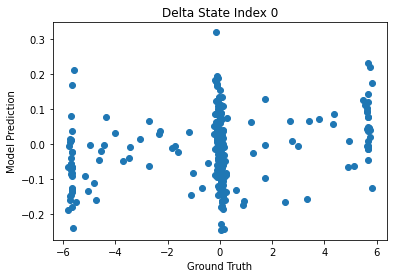

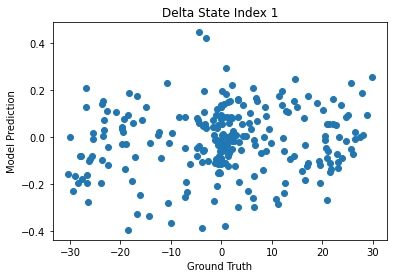

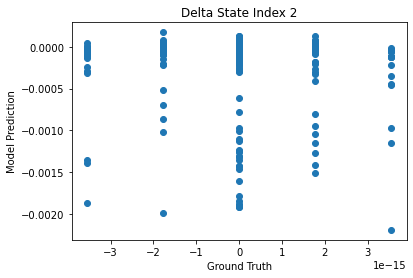

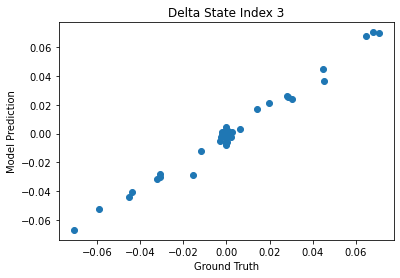

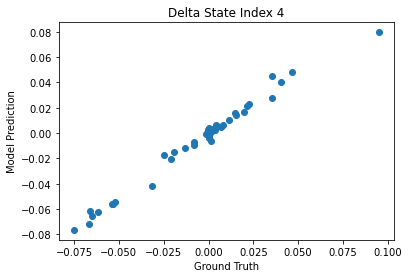

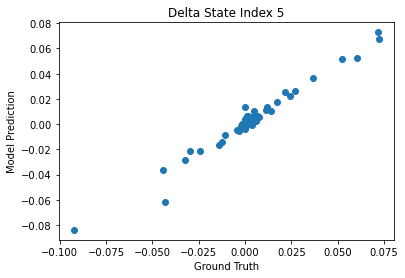

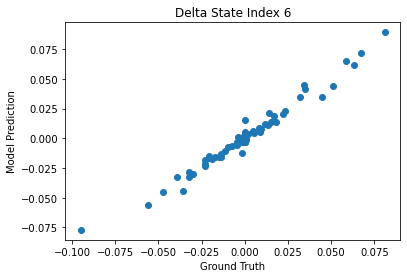

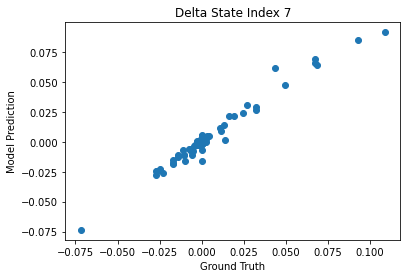

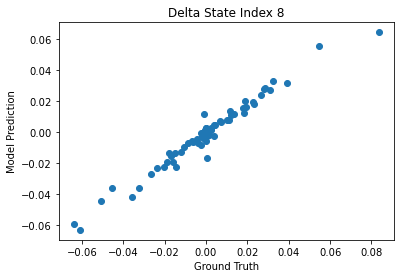

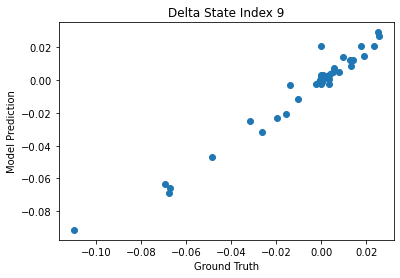

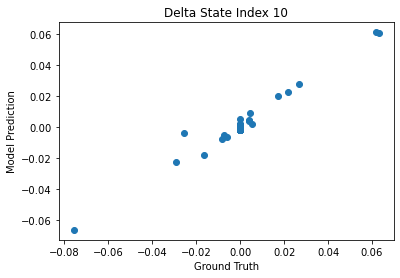

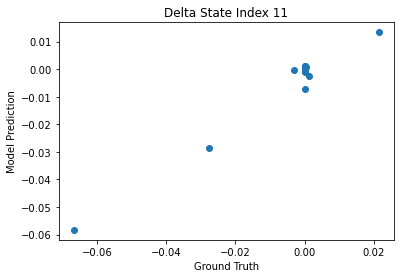

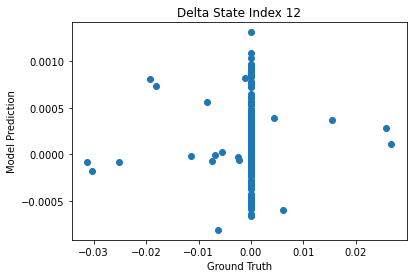

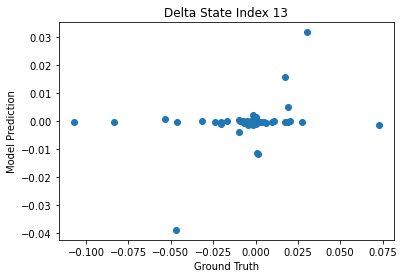

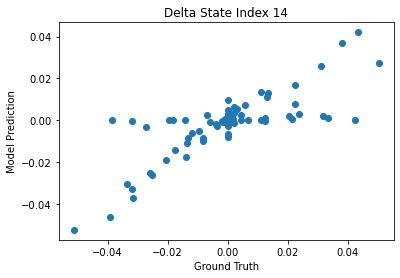

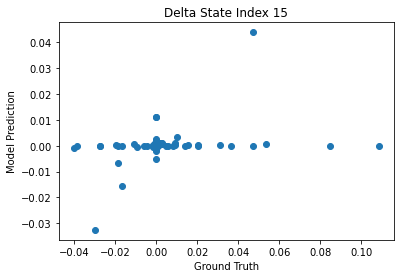

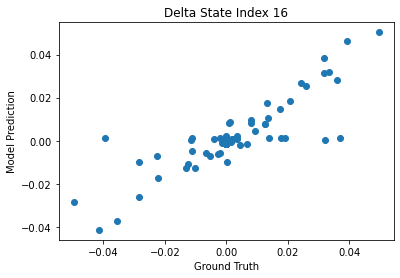

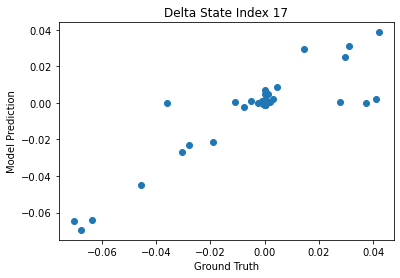

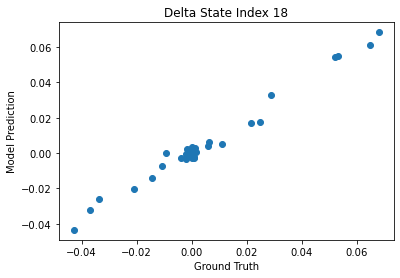

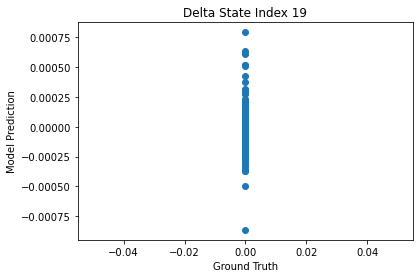

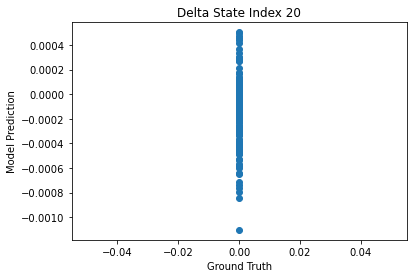

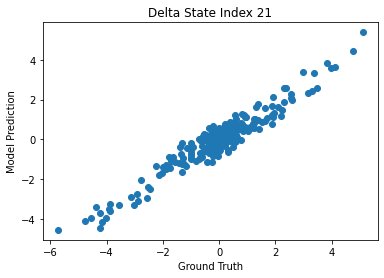

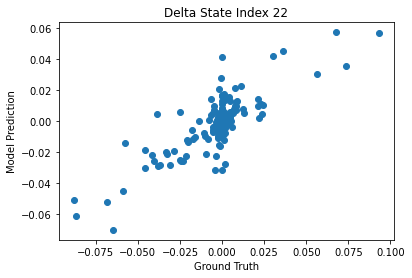

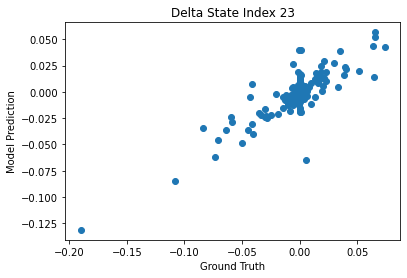

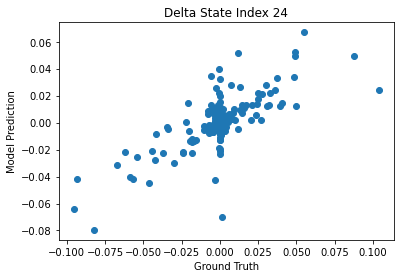

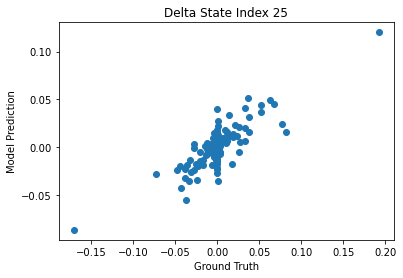

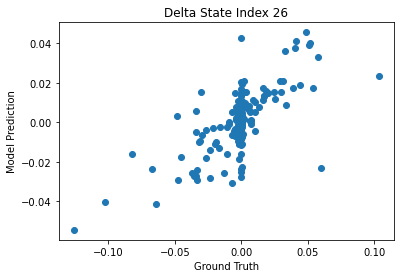

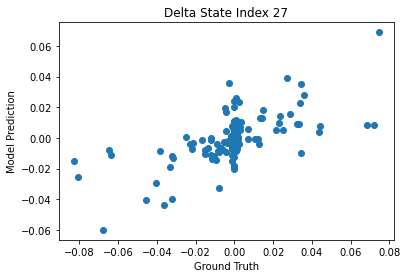

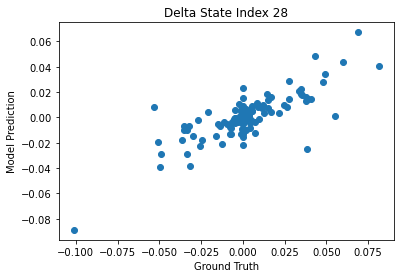

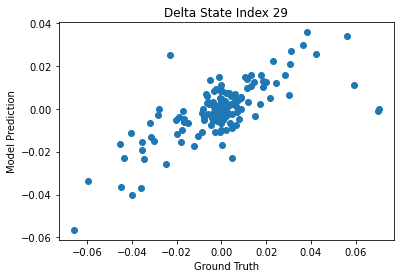

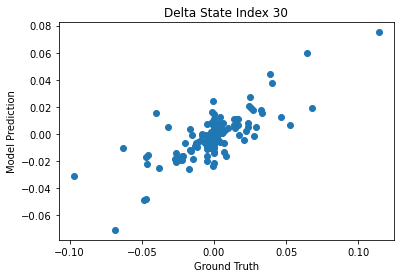

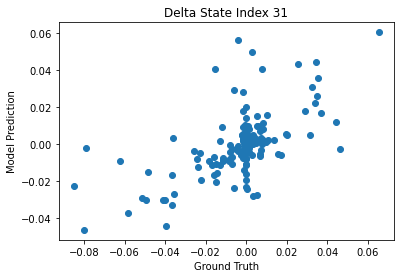

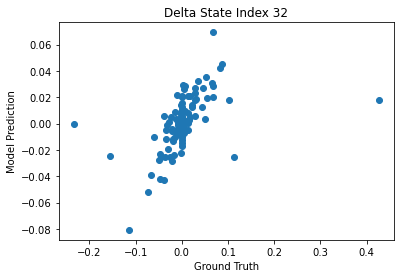

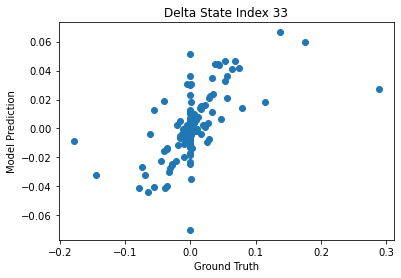

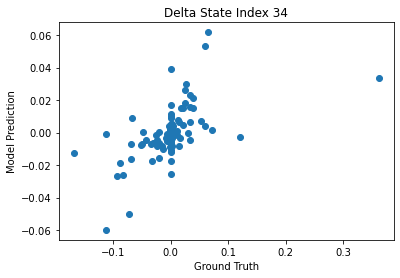

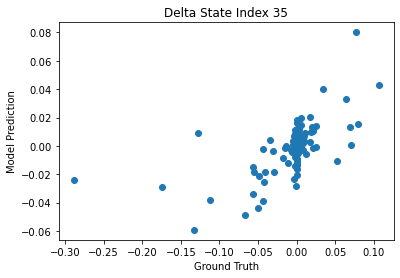

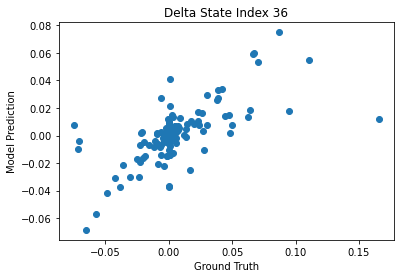

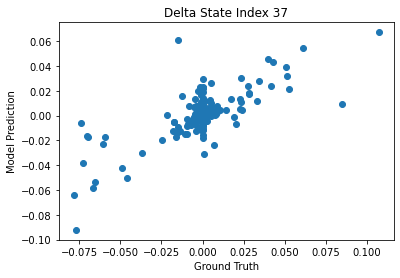

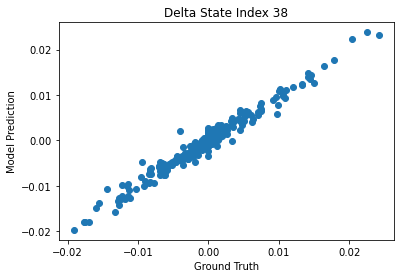

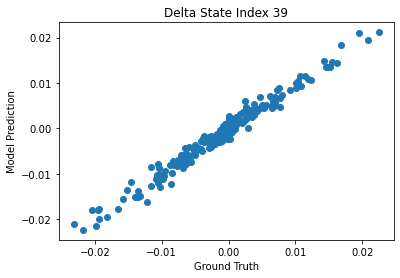

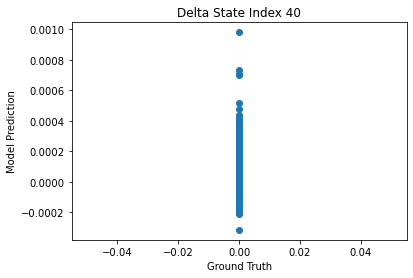

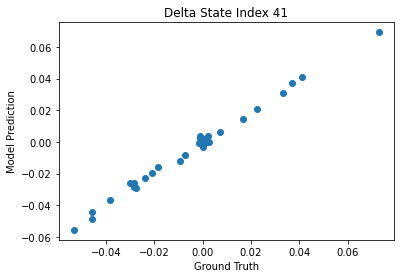

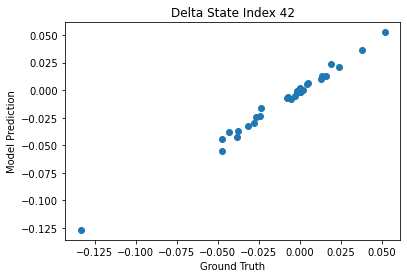

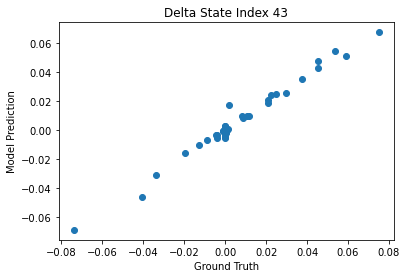

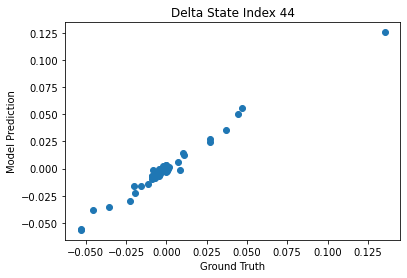

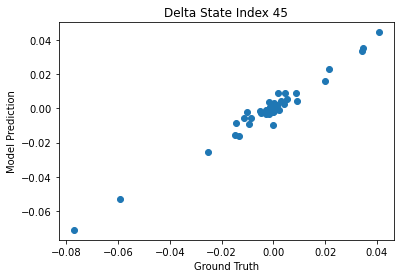

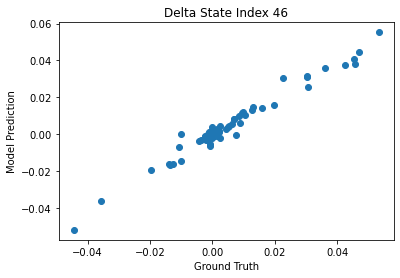

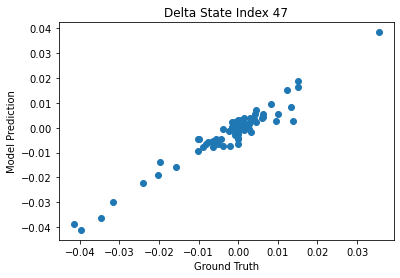

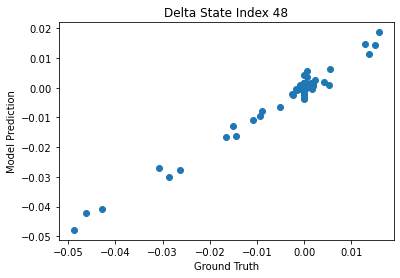

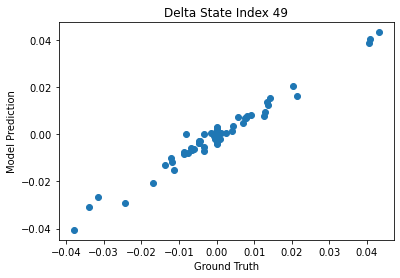

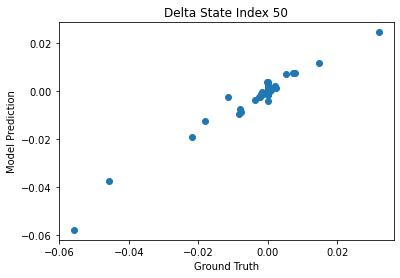

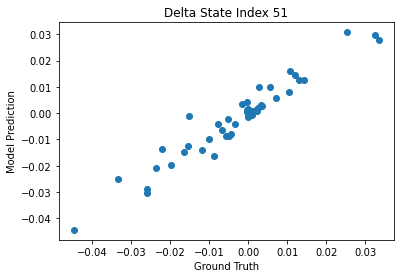

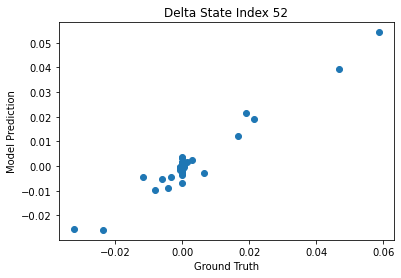

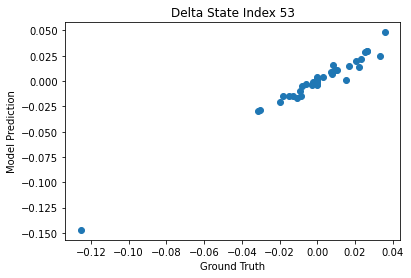

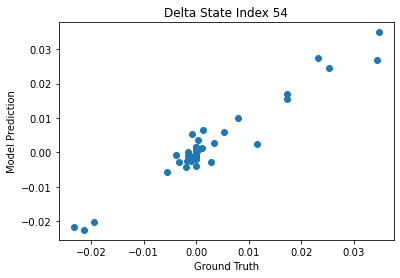

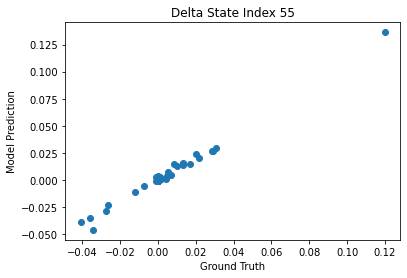

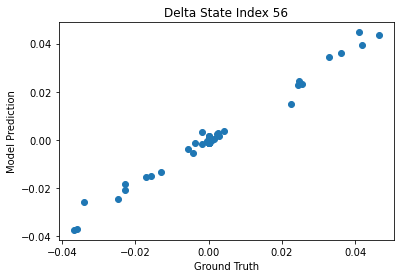

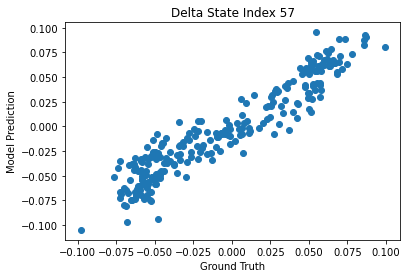

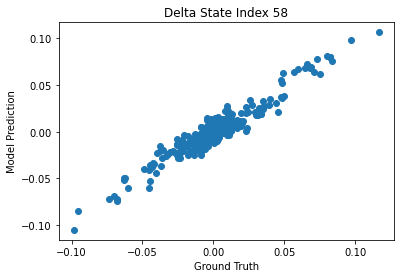

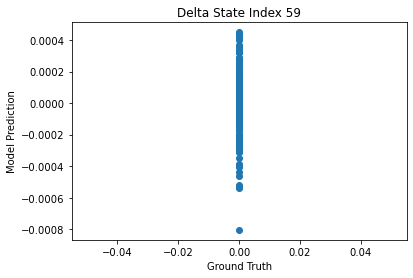

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

for i in range(next_states.shape[1]):
    plt.plot(next_states[:,i] - states[:,i], pred_next_states[:,i] - states[:,i], "o")
    plt.title(f"Delta State Index {i}")
    plt.xlabel("Ground Truth")
    plt.ylabel("Model Prediction")
    plt.figure()


Text(0, 0.5, 'Model Prediction')

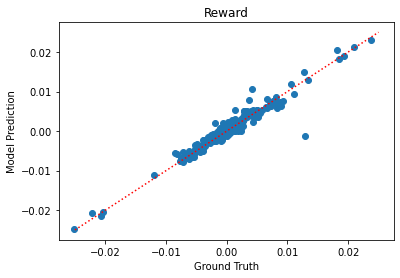

In [17]:
plt.plot(rewards[:,0], pred_rewards[:,0], "o")
plt.plot((-0.025, 0.025), (-0.025, 0.025), "r:")
plt.title("Reward")
plt.xlabel("Ground Truth")
plt.ylabel("Model Prediction")

In [10]:
state, action, reward, next_state, done = env_pool.sample(len(env_pool))

delta_state = next_state - state
inputs = np.concatenate((state, action), axis=-1)

reward = np.reshape(reward, (reward.shape[0], -1))
labels = np.concatenate((reward, delta_state), axis=-1)

val_mse, val_nll = predict_env.model.train(inputs, labels, batch_size=256)
val_mse

0.20535413920879364

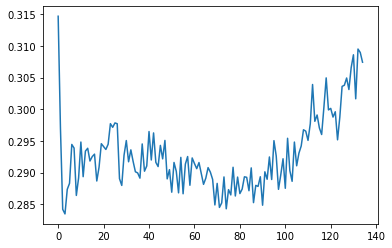

In [28]:
import matplotlib.pyplot as plt
plt.plot(logged_data["Model/model_rmse"])

In [62]:
for _ in range(100):
    expert_states, expert_actions, _, _, _ = expert_pool.sample(args.policy_train_batch_size)
    expert_states = torch.FloatTensor(expert_states).to(agent.device)
    expert_actions = torch.FloatTensor(expert_actions).to(agent.device)
    # mean, _ = agent.policy(expert_states)
    # policy_loss = torch.nn.MSELoss()(mean, expert_actions)
    agent.policy_optim.zero_grad()
    log_prob, _, _ = agent.policy.log_prob(expert_states, expert_actions)
    policy_loss = -log_prob.mean()
    policy_loss.backward()
    agent.policy_optim.step()
    loss_val = policy_loss.cpu().detach().item()
    wandb.log({"Policy/loss": loss_val})


{'Policy/loss': 369269.9375}
{'Policy/loss': 292106.59375}
{'Policy/loss': 27.654129028320312}
{'Policy/loss': 27.49703025817871}
{'Policy/loss': 27.40135955810547}
{'Policy/loss': 27.127239227294922}
{'Policy/loss': 27.125579833984375}
{'Policy/loss': 26.87480926513672}
{'Policy/loss': 26.781635284423828}
{'Policy/loss': 26.714279174804688}
{'Policy/loss': 562.8302612304688}
{'Policy/loss': 26.428424835205078}
{'Policy/loss': 26.318622589111328}
{'Policy/loss': 26.176294326782227}
{'Policy/loss': 26.180397033691406}
{'Policy/loss': 26.041324615478516}
{'Policy/loss': 168.80418395996094}
{'Policy/loss': 25.865596771240234}
{'Policy/loss': 26.008235931396484}
{'Policy/loss': 25.666664123535156}
{'Policy/loss': 25.89952850341797}
{'Policy/loss': 5923.73046875}
{'Policy/loss': 90.87991333007812}
{'Policy/loss': 5078.369140625}
{'Policy/loss': 25.56700897216797}
{'Policy/loss': 25.60506248474121}
{'Policy/loss': 25.763811111450195}
{'Policy/loss': 3883.132568359375}
{'Policy/loss': 25.6118